In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Precision and Recall (PR)
- run PR comparing Brinton et al 2020 hap blocks
- Use chr5B. There are different genome references that share blocks

### Step1:
- Combine Affinity Propagation (AP) haplotypes and Brinton haplotypes.
- The chr5B AP is a file created in astep before.
- Calculate PR by shared block by reference.
- Estimate the percentage across the genome under different parameters.

### Libraries

In [2]:
import pandas as pd
import numpy as np
import argparse
from sklearn.cluster import AffinityPropagation
from warnings import filterwarnings
filterwarnings('ignore')
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

In [3]:
def map_references(df, references_names):    
    df['query'] = df['query'].map(references_names)
    return df


def filter_by_samples(df, reference, query):
    filtered_df = df[(df['query']== reference) | \
                                    (df['query']== query)]
    return filtered_df


def get_alignment_blocks(file, reference, query, chromosome):
    alignment_df = pd.read_csv(alignment_f, delimiter='\t')
    queries_IBS = alignment_df[(alignment_df['ref'] == reference) & \
                                     (alignment_df['query'] == query) & \
                                     (alignment_df['chrom'] == chromosome)]
    return queries_IBS


def assign_ibs_blocks(ibspy_df, alignment_df):
    ibspy_df['aln_ibs'] = 0
    for index, row in alignment_df.iterrows():
        ibspy_df['aln_ibs'] = np.where((ibspy_df['start'] >= row['ref_start']) &
                                       (ibspy_df['start'] <= row['ref_end']),
                                       1, ibspy_df['aln_ibs'])
    return ibspy_df


def get_highest_dmp(df, column, sufix, dmps):
    sc_list=[]
    for dmp in dmps:
        sc_list.append(f'sc_{dmp}')
    df['sc_max'] = df[sc_list].idxmax(axis=1)
    df['sc_max'] = df['sc_max'].str.split('_', expand=True)[1]
    df['sc_max'] = 'dmp_' + df['sc_max'].astype(str)
    
    dmps_list=[]
    for dmp in dmps:
        dmps_list.append(f'dmp_{dmp}')
    df['dmp_hap'] = 0
    for dmp in dmps_list:
        df['dmp_hap'] = np.where(df['sc_max'] == dmp, df[f'{dmp}'], df['dmp_hap'])
    return df


def get_precision_recall(df, dmps, average):
    df_list = []
    scores = ['precision', 'recall', 'fscore']
    for dmp in dmps:
        y_true = df['aln_ibs']
        y_pred = df[f'dmp_{dmp}']
        precision = precision_recall_fscore_support(y_true, y_pred, average=average)
        pred_df = pd.DataFrame(precision[:-1], columns=[f'dmp_{dmp}'], index=scores)
        df_list.append(pred_df)
    dfs = pd.concat(df_list, axis=1)
    dfs['ref'], dfs['query']  = df['ref'].unique()[0], df['query'].unique()[0]
    return dfs


### Files

In [4]:
chromosome = 'chr2D'
reference='mattis-pg'
query='julius-pg'
windows_no = 9
windows_ibspy = 100000
file=f'chr2D_9w_100000ibs_0-651852609bp_long_qc_extended.tsv.gz'

In [5]:
alignment_f = '/Users/quirozc/Documents/PhD_2020/16_watseq/04_haplotype_grouping/25_QC_metrics/data/haplotype_blocks_5Mb_Brinton_2020.txt'
affinity_f=f'/Users/quirozc/Documents/PhD_2020/16_watseq/04_haplotype_grouping/25_QC_metrics/hpc_data/{file}'

In [6]:
affinity_df = pd.read_csv(affinity_f, delimiter='\t')
affinity_df.head(2)

,chr,start,end,query,window,variations,dmp_0.99,sc_0.99,dmp_0.98,sc_0.98,...,dmp_0.9,sc_0.9,dmp_0.8,sc_0.8,dmp_0.7,sc_0.7,dmp_0.6,sc_0.6,dmp_0.5,sc_0.5
0,chr2D__chi,1,500000,Agron,chr2D_200000,171,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19
1,chr2D__chi,1,500000,Agron,chr2D_300000,116,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19


## Rename samples to match both files

In [7]:
references_names = {\
        'Cadenza-15x':'cadenza',
        'Chinese-10x':'chinese',
        'Chinese_Spring':'chinese-pg',
        'Claire':'claire',
        'Jagger-pg':'jagger',
        'Jagger-10x':'jagger-10x',
        'Julius-pg':'julius-pg',
        'Julius-10x':'julius-10x',
        'Lancer-10x':'lancer',
        'Landmark-pg':'landmark',
        'Norin61-pg':'norin61',
        'Paragon-12x':'paragon',
        'Stanley-12x':'stanley',
        'robigus':'robigus',
        'Robigus-10x':'robigus-10x',
        'Flame':'flame',
        'wasp':'wasp',
        'Hobbit':'hobbit',
        'Revelation':'revelation',
        'Galahad':'galahad',
        'Boxer':'boxer',   
        'Mattis-12x':'mattis',
        'Mattis-pg':'mattis-pg',
        'Arina-10x':'arina-10x',
        'Arina-pg':'arina-pg',
        'Mace-pg':'mace-pg'}

In [8]:
affinity_df_mapped = map_references(affinity_df, references_names)
affinity_df_mapped.head(10)

,chr,start,end,query,window,variations,dmp_0.99,sc_0.99,dmp_0.98,sc_0.98,...,dmp_0.9,sc_0.9,dmp_0.8,sc_0.8,dmp_0.7,sc_0.7,dmp_0.6,sc_0.6,dmp_0.5,sc_0.5
0,chr2D__chi,1,500000,NaN,chr2D_200000,171,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19
1,chr2D__chi,1,500000,NaN,chr2D_300000,116,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19
2,chr2D__chi,1,500000,NaN,chr2D_400000,62,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19
3,chr2D__chi,1,500000,NaN,chr2D_500000,45,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19
4,chr2D__chi,1,500000,NaN,chr2D_WhAri_100000,258,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19
5,chr2D__chi,1,500000,NaN,chr2D_WhAri_200000,100,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19
6,chr2D__chi,1,500000,NaN,chr2D_WhAri_300000,60,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19
7,chr2D__chi,1,500000,NaN,chr2D_WhAri_400000,34,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19
8,chr2D__chi,1,500000,NaN,chr2D_WhAri_500000,75,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19
9,chr2D__chi,1,500000,NaN,chr2D_WhJag_2000000,62,12,0.36,12,0.36,...,25,0.17,19,0.18,18,0.18,19,0.19,17,0.19


In [9]:
aff_mapped_filtered_df = affinity_df_mapped
affinity_df_filtered = aff_mapped_filtered_df.dropna()
affinity_df_filtered.head(5)

,chr,start,end,query,window,variations,dmp_0.99,sc_0.99,dmp_0.98,sc_0.98,...,dmp_0.9,sc_0.9,dmp_0.8,sc_0.8,dmp_0.7,sc_0.7,dmp_0.6,sc_0.6,dmp_0.5,sc_0.5
512424,chr2D__chi,1,500000,arina-10x,chr2D_200000,15,7,0.36,7,0.36,...,15,0.17,16,0.18,15,0.18,16,0.19,43,0.19
512425,chr2D__chi,1,500000,arina-10x,chr2D_300000,19,7,0.36,7,0.36,...,15,0.17,16,0.18,15,0.18,16,0.19,43,0.19
512426,chr2D__chi,1,500000,arina-10x,chr2D_400000,30,7,0.36,7,0.36,...,15,0.17,16,0.18,15,0.18,16,0.19,43,0.19
512427,chr2D__chi,1,500000,arina-10x,chr2D_500000,19,7,0.36,7,0.36,...,15,0.17,16,0.18,15,0.18,16,0.19,43,0.19
512428,chr2D__chi,1,500000,arina-10x,chr2D_WhAri_100000,4,7,0.36,7,0.36,...,15,0.17,16,0.18,15,0.18,16,0.19,43,0.19


In [10]:
affinity_df_filtered['query'].unique()

array(['arina-10x', 'arina-pg', 'boxer', 'cadenza', 'chinese',
       'chinese-pg', 'claire', 'flame', 'galahad', 'hobbit', 'jagger-10x',
       'jagger', 'julius-10x', 'julius-pg', 'lancer', 'landmark',
       'mace-pg', 'mattis', 'mattis-pg', 'norin61', 'paragon',
       'revelation', 'robigus-10x', 'stanley', 'robigus', 'wasp'],
      dtype=object)

## Filter by samples to test IBS

In [11]:
affinity_by_sample = filter_by_samples(affinity_df_filtered, reference, query)
affinity_by_sample['query'].unique()

array(['julius-pg', 'mattis-pg'], dtype=object)

## Split above DF in two by query

In [12]:
def get_df_by_sample(df):
    df1,df2 = [y for x, y in df.groupby('query', as_index=False)]
    df1.reset_index(inplace=True, drop=True)
    df2.reset_index(inplace=True, drop=True)
    return df1, df2

df1, df2 = get_df_by_sample(affinity_by_sample)
print(df1['query'].unique()[0], df2['query'].unique()[0])

julius-pg mattis-pg


In [13]:
def merge_df(df1, df2):
    df3 = df1.drop(['query','variations'], axis=1)
    df3.insert(loc=4, column='ref',value = df1['query'])
    df3.insert(loc=5, column=df1['query'].unique()[0],value=df1['variations'])
    df3.insert(loc=6, column='query',value=df2['query'])
    df3.insert(loc=7, column=df2['query'].unique()[0],value=df2['variations'])
    df3 = df3.iloc[:,:8]
    return df3

merged_by_sample_df = merge_df(df2,df1)
merged_by_sample_df.head(2)

,chr,start,end,window,ref,mattis-pg,query,julius-pg
0,chr2D__chi,1,500000,chr2D_200000,mattis-pg,7,julius-pg,11
1,chr2D__chi,1,500000,chr2D_300000,mattis-pg,18,julius-pg,29


## Aligment data

In [14]:
reference_aln = 'mattis'
query_aln = 'julius'

alignment_blocks_df = get_alignment_blocks(alignment_f, reference_aln, query_aln, chromosome)
alignment_blocks_df.head(2)

,ref,query,chrom,ref_start,ref_end,source,block_no,ref_assembly,block_size,ref_chrom,bin_size_mbp
2073,mattis,julius,chr2D,545000000,570000000,nucmer,2008,mattis,25000000,chr2D__sym,5
2087,mattis,julius,chr2D,610000000,630000000,nucmer,2023,mattis,20000000,chr2D__sym,5


In [15]:
ibspy_with_alignment = assign_ibs_blocks(merged_by_sample_df, alignment_blocks_df)
ibspy_with_alignment.head(2)

,chr,start,end,window,ref,mattis-pg,query,julius-pg,aln_ibs
0,chr2D__chi,1,500000,chr2D_200000,mattis-pg,7,julius-pg,11,0
1,chr2D__chi,1,500000,chr2D_300000,mattis-pg,18,julius-pg,29,0


In [16]:
dmps = ['0.5','0.6','0.7','0.8','0.9','0.91','0.92','0.93','0.94','0.95','0.96','0.97','0.98','0.99']
for dmp in dmps:
    ibspy_with_alignment[f'dmp_{dmp}'] = np.where(df1[f'dmp_{dmp}'] == df2[f'dmp_{dmp}'],1,0)
    ibspy_with_alignment[f'sc_{dmp}'] = df1[f'sc_{dmp}']

In [17]:
ibspy_with_alignment = get_highest_dmp(ibspy_with_alignment, 'sc_max', 'dmp_', dmps)
ibspy_with_alignment.head(10)

,chr,start,end,window,ref,mattis-pg,query,julius-pg,aln_ibs,dmp_0.5,...,dmp_0.96,sc_0.96,dmp_0.97,sc_0.97,dmp_0.98,sc_0.98,dmp_0.99,sc_0.99,sc_max,dmp_hap
0,chr2D__chi,1,500000,chr2D_200000,mattis-pg,7,julius-pg,11,0,0,...,1,0.36,1,0.36,1,0.36,1,0.36,dmp_0.95,1
1,chr2D__chi,1,500000,chr2D_300000,mattis-pg,18,julius-pg,29,0,0,...,1,0.36,1,0.36,1,0.36,1,0.36,dmp_0.95,1
2,chr2D__chi,1,500000,chr2D_400000,mattis-pg,24,julius-pg,53,0,0,...,1,0.36,1,0.36,1,0.36,1,0.36,dmp_0.95,1
3,chr2D__chi,1,500000,chr2D_500000,mattis-pg,11,julius-pg,23,0,0,...,1,0.36,1,0.36,1,0.36,1,0.36,dmp_0.95,1
4,chr2D__chi,1,500000,chr2D_WhAri_100000,mattis-pg,35,julius-pg,66,0,0,...,1,0.36,1,0.36,1,0.36,1,0.36,dmp_0.95,1
5,chr2D__chi,1,500000,chr2D_WhAri_200000,mattis-pg,19,julius-pg,13,0,0,...,1,0.36,1,0.36,1,0.36,1,0.36,dmp_0.95,1
6,chr2D__chi,1,500000,chr2D_WhAri_300000,mattis-pg,22,julius-pg,31,0,0,...,1,0.36,1,0.36,1,0.36,1,0.36,dmp_0.95,1
7,chr2D__chi,1,500000,chr2D_WhAri_400000,mattis-pg,19,julius-pg,33,0,0,...,1,0.36,1,0.36,1,0.36,1,0.36,dmp_0.95,1
8,chr2D__chi,1,500000,chr2D_WhAri_500000,mattis-pg,26,julius-pg,33,0,0,...,1,0.36,1,0.36,1,0.36,1,0.36,dmp_0.95,1
9,chr2D__chi,1,500000,chr2D_WhJag_2000000,mattis-pg,2,julius-pg,32,0,0,...,1,0.36,1,0.36,1,0.36,1,0.36,dmp_0.95,1


In [18]:
reference = ibspy_with_alignment['ref'].unique()[0]
query = ibspy_with_alignment['query'].unique()[0]
# ibspy_with_alignment.to_csv(f'{chromosome}_{reference}_{query}_ap_dmp_combined_hap_{windows_no}_{windows_ibspy}.tsv', sep='\t', index=False)

## Get Precision and Recall after combine dmps

In [19]:
dmps = ['0.5','0.6','0.7','0.8','0.9','0.91','0.92','0.93','0.94','0.95','0.96','0.97','0.98','0.99','hap']

average = 'binary'
# {‘binary’, ‘micro’, ‘macro’, ‘weighted’}, default=None
precision_recall_pred = get_precision_recall(ibspy_with_alignment, dmps, average)
precision_recall_pred
precision_recall_pred.index.name = 'metric'
precision_recall_pred.reset_index(inplace=True)
precision_recall_pred_melt = precision_recall_pred.iloc[:, :-2].melt('metric', var_name='dmp', value_name='score')
precision_recall_pred_melt
plot_df = precision_recall_pred_melt[precision_recall_pred_melt['metric'] == 'fscore']


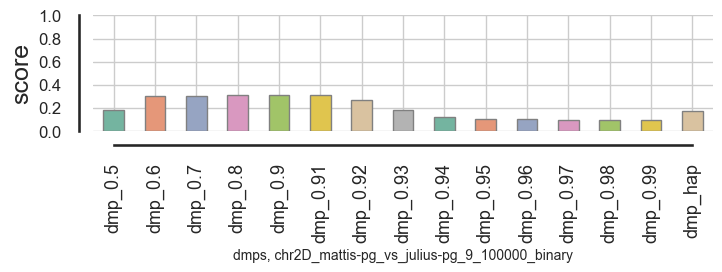

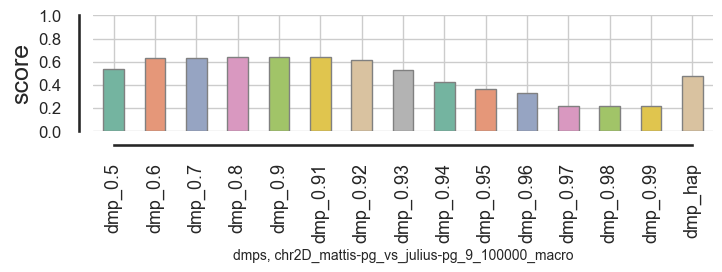

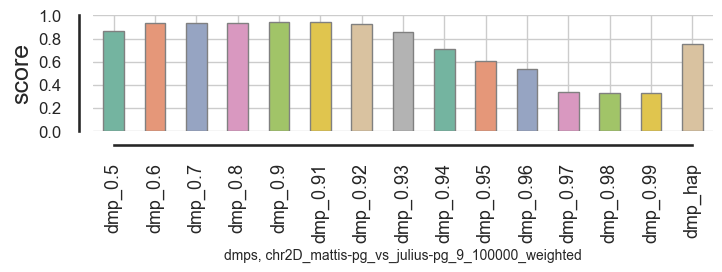

In [20]:
from matplotlib import pyplot as plt

dmps = ['0.5','0.6','0.7','0.8','0.9','0.91','0.92','0.93','0.94','0.95','0.96','0.97','0.98','0.99','hap']

averages = ['binary', 'macro', 'weighted']
for average in averages:
    # {‘binary’, ‘micro’, ‘macro’, ‘weighted’}, default=None
    precision_recall_pred = get_precision_recall(ibspy_with_alignment, dmps, average)
    precision_recall_pred
    precision_recall_pred.index.name = 'metric'
    precision_recall_pred.reset_index(inplace=True)
    precision_recall_pred_melt = precision_recall_pred.iloc[:, :-2].melt('metric', var_name='dmp', value_name='score')
    precision_recall_pred_melt
    plot_df = precision_recall_pred_melt[precision_recall_pred_melt['metric'] == 'fscore']




    font_s = 10
    font_w = "bold"


    plt.figure(figsize=(8,1.5))

    sns.set_theme(style="white", context="talk")
    ax = sns.barplot(x='dmp', y='score', data=plot_df, palette="Set2",linewidth=1, edgecolor=".5", width=.5, saturation=.7)
    # ax.legend(ncol=3,loc='upper right',borderpad=0.1,labelspacing=0.1,columnspacing=1)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.set_ylim([0,1])
    sns.despine(offset=10, trim=True, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=90, fontsize=13)
    # plt.setp(ax.get_yticklabels(), fontsize=10)
    plt.yticks(list(np.arange(0, 1.2, 0.2)), fontsize = 12)
    # ax.set_title(f'{chromosome}_{reference}_vs_{query}_{windows_no}_{windows_ibspy}',fontsize=20,fontweight="bold")
    plt.grid(True, linewidth=1)
    plt.xlabel(f'dmps, {chromosome}_{reference}_vs_{query}_{windows_no}_{windows_ibspy}_{average}',fontsize = font_s)
    # plt.tight_layout(h_pad=2)

In [21]:
# precision_recall_pred.to_csv(f'{chromosome}_{reference}_{query}_ap_precision_recall_{windows_no}_{windows_ibspy}_{average}.tsv', sep='\t', index=True)

In [22]:
precision_recall_pred.index.name = 'metric'
precision_recall_pred.reset_index(inplace=True)

ValueError: cannot insert metric, already exists

In [ ]:
precision_recall_pred_melt = precision_recall_pred.iloc[:, :-2].melt('metric', var_name='dmp', value_name='score')
precision_recall_pred_melt
plot_df = precision_recall_pred_melt[precision_recall_pred_melt['metric'] == 'fscore']

# plot_df

In [ ]:
from matplotlib import pyplot as plt


font_s = 10
font_w = "bold"


plt.figure(figsize=(8,1.5))

sns.set_theme(style="white", context="talk")
ax = sns.barplot(x='dmp', y='score', data=plot_df, palette="Set2",linewidth=1, edgecolor=".5", width=.5, saturation=.7)
# ax.legend(ncol=3,loc='upper right',borderpad=0.1,labelspacing=0.1,columnspacing=1)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set_ylim([0,1])
sns.despine(offset=10, trim=True, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=13)
# plt.setp(ax.get_yticklabels(), fontsize=10)
plt.yticks(list(np.arange(0, 1.2, 0.2)), fontsize = 12)
# ax.set_title(f'{chromosome}_{reference}_vs_{query}_{windows_no}_{windows_ibspy}',fontsize=20,fontweight="bold")
plt.grid(True, linewidth=1)
plt.xlabel(f'dmps, {chromosome}_{reference}_vs_{query}_{windows_no}_{windows_ibspy}_{average}',fontsize = font_s)
# plt.tight_layout(h_pad=2)

In [ ]:
from matplotlib import pyplot as plt


font_s = 10
font_w = "bold"


plt.figure(figsize=(10,1.5))

sns.set_theme(style="white", context="talk")
ax = sns.barplot(x='dmp', y='score', hue="metric", data=precision_recall_pred_melt, palette="Set2",linewidth=1, edgecolor=".5", width=.7, saturation=.7)
# ax.legend(ncol=3,loc='upper right',borderpad=0.1,labelspacing=0.1,columnspacing=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set_ylim([0,1])
sns.despine(offset=10, trim=True, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=13)
# plt.setp(ax.get_yticklabels(), fontsize=10)
plt.yticks(list(np.arange(0, 1.2, 0.2)), fontsize = 12)
# ax.set_title(f'{chromosome}_{reference}_vs_{query}_{windows_no}_{windows_ibspy}',fontsize=20,fontweight="bold")
plt.grid(True, linewidth=1)
plt.xlabel(f'dmps, {chromosome}_{reference}_vs_{query}_{windows_no}_{windows_ibspy}_{average}',fontsize = font_s)
# plt.tight_layout(h_pad=2)



In [ ]:
from matplotlib import pyplot as plt


font_s = 10
font_w = "bold"


plt.figure(figsize=(8,1.5))

sns.set_theme(style="white", context="talk")
ax = sns.barplot(x='dmp', y='score', data=plot_df, palette="Set2",linewidth=1, edgecolor=".5", width=.5, saturation=.7)
# ax.legend(ncol=3,loc='upper right',borderpad=0.1,labelspacing=0.1,columnspacing=1)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.set_ylim([0,1])
sns.despine(offset=10, trim=True, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=13)
# plt.setp(ax.get_yticklabels(), fontsize=10)
plt.yticks(list(np.arange(0, 1.2, 0.2)), fontsize = 12)
# ax.set_title(f'{chromosome}_{reference}_vs_{query}_{windows_no}_{windows_ibspy}',fontsize=20,fontweight="bold")
plt.grid(True, linewidth=1)
plt.xlabel(f'dmps, {chromosome}_{reference}_vs_{query}_{windows_no}_{windows_ibspy}_{average}',fontsize = font_s)
# plt.tight_layout(h_pad=2)


In [ ]:
def plot_haplotypes(df, dmp, title):
    haplotypes = sorted(df[dmp].unique())

    left  = 0.125  
    right = 0.9    
    bottom = 0.1  
    top = 0.9      
    wspace = 0.1  
    hspace = 0.9

    f, axes = plt.subplots(round(len(haplotypes)/3), 3, figsize=(40,15), sharex=True)
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    f.suptitle(title,fontsize=18,fontweight="bold")
    # f.text(0.5, 0.001, 'common Y', ha='center', va="center", fontsize=20)

    y = 0
    plt.figure()

    for hap in haplotypes:
        i, j = divmod(y, 3)
        df_filtered = df[df[dmp]== hap]
        n_samples = len(df_filtered['query'].unique())

        sns.set_theme(style="ticks", palette="pastel")
        ax = sns.boxplot(x='window', y="variations", data=df_filtered, ax=axes[i, j])
        ax.set_title(f'hap_{hap}'+'\n'+f'n = {n_samples}',fontsize=12,fontweight="bold")
        sns.despine(offset=10, trim=True, ax=ax)
        plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)

        ax.axes.get_xaxis().get_label().set_visible(False)
        y = y + 1

#     plt.show()